In [1]:
cd drive/My\ Drive/concrete_crack

/content/drive/My Drive/concrete_crack


In [2]:
import numpy as np
import keras.utils
from keras.layers import Input, Dense, Flatten
from keras.models import load_model, Model
from keras.layers import Conv2D, UpSampling2D, AveragePooling2D
from keras.layers import LeakyReLU, Reshape
from keras.datasets import mnist
from keras.models import save_model
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import time

Using TensorFlow backend.


In [0]:
import os

In [0]:
def generateTheta(L, endim):
  sample = np.random.uniform(size = (L, endim))
  theta = [w/np.sqrt((w**2).sum()) for w in sample]
  return np.asarray(theta)

def generateZ(batchsize, endim):
  z = np.random.uniform(size = (batchsize, endim))
  z = z - 0.5
  z = 2*z 
  return z

In [0]:
L = 50
batchsize = 64
endim = 2

In [6]:
img = Input(shape = (28,28,1))
x = Conv2D(16, (3,3), padding = 'same')(img)
x = LeakyReLU(alpha = 0.2)(x)
x = Conv2D(16, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = AveragePooling2D((2,2), padding = 'same')(x) #(none, 14, 14, 16)

x = Conv2D(32, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Conv2D(32, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = AveragePooling2D((2,2), padding = 'same')(x) #(none, 7, 7, 32)

x = Conv2D(64, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Conv2D(64, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = AveragePooling2D((2,2), padding = 'same')(x) #(none, 4, 4, 64)

x = Flatten()(x) #(none, 4*4*64)
x = Dense(128, activation = 'relu')(x)
encoded = Dense(endim)(x)

encoder = Model(inputs = [img], outputs = [encoded])
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        4640

In [7]:
embedd = Input(shape = (endim, ))
x = Dense(128)(embedd)
x = Dense(4*4*64, activation = 'relu')(x)
x = Reshape((4,4,64))(x)
x = UpSampling2D((2,2))(x) #(none, 8, 8, 64)

x = Conv2D(64, (3,3), padding='same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Conv2D(64, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = UpSampling2D((2,2))(x) #(none, 16, 16, 64)

x = Conv2D(64, (3,3), padding = 'valid')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Conv2D(64, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = UpSampling2D((2,2))(x) #(none, 28, 28, 64)

x = Conv2D(32, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Conv2D(32, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
decoded = Conv2D(1, (3,3), padding = 'same', activation = 'sigmoid')(x)

decoder = Model(inputs = [embedd], outputs = [decoded])
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              132096    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 64)          0   

In [0]:
theta = K.variable(generateTheta(L, endim))
z = K.variable(generateZ(batchsize, endim))

In [9]:
encoded_image = encoder(img)
decoded_image = decoder(encoded_image)
autoencoder = Model(inputs = [img], outputs = [decoded_image])
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 203250    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         308193    
Total params: 511,443
Trainable params: 511,443
Non-trainable params: 0
_________________________________________________________________


In [0]:
proj_encoded = K.dot(encoded_image, K.transpose(theta))
proj_z = K.dot(z, K.transpose(theta))

In [0]:
proj_encoded_transposed = tf.nn.top_k(tf.transpose(proj_encoded), k = batchsize).values
proj_z_transposed = tf.nn.top_k(tf.transpose(proj_z), k = batchsize).values
w2 = (proj_encoded_transposed - proj_z_transposed)**2
w2weight = K.variable(10.0)
w2loss = w2weight * K.mean(w2)

In [0]:
crossEntropy = K.binary_crossentropy(K.flatten(img), K.flatten(decoded_image))
crossEntropyLoss = (1.0) * K.mean(crossEntropy)

In [0]:
l1Loss = (1.0) * K.mean(K.abs(K.flatten(img) - K.flatten(decoded_image)))

In [0]:
total_loss = w2loss + crossEntropyLoss + l1Loss

In [0]:
autoencoder.add_loss(total_loss)

In [16]:
autoencoder.compile(optimizer = 'rmsprop', loss = '')

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output model_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_2.
  'be expecting any data to be passed to {0}.'.format(name))


In [17]:
cd data_28

/content/drive/My Drive/concrete_crack/data_28


In [0]:
X_train = np.load('X_train.npy', allow_pickle=True)

In [20]:
history = autoencoder.fit(X_train, None, validation_split=0.2, epochs = 100, batch_size = 64)

Train on 12800 samples, validate on 3200 samples
Epoch 1/100
12800/12800 [==============================] - 8s 652us/step - loss: 2.9352 - val_loss: 1.5038
Epoch 2/100
12800/12800 [==============================] - 8s 601us/step - loss: 2.1448 - val_loss: 1.6183
Epoch 3/100
12800/12800 [==============================] - 8s 601us/step - loss: 1.6907 - val_loss: 1.5445
Epoch 4/100
12800/12800 [==============================] - 8s 599us/step - loss: 1.4320 - val_loss: 2.0664
Epoch 5/100
12800/12800 [==============================] - 8s 601us/step - loss: 1.3053 - val_loss: 1.2957
Epoch 6/100
12800/12800 [==============================] - 8s 603us/step - loss: 1.2526 - val_loss: 0.9157
Epoch 7/100
12800/12800 [==============================] - 8s 605us/step - loss: 1.1642 - val_loss: 1.7586
Epoch 8/100
12800/12800 [==============================] - 8s 602us/step - loss: 1.1199 - val_loss: 0.8693
Epoch 9/100
12800/12800 [==============================] - 8s 611us/step - loss: 1.0885 - val_l

In [21]:
cd ..

/content/drive/My Drive/concrete_crack


In [0]:
os.mkdir('model3')

In [23]:
cd model3/

/content/drive/My Drive/concrete_crack/model3


In [0]:
save_model(encoder,filepath='encoder.h5')
save_model(decoder,filepath='decoder.h5')
save_model(autoencoder,filepath='autoencoder.h5')

In [0]:
np.save('model1_history', history.history, allow_pickle=True)

In [0]:
np.save('training_loss', history.history['loss'], allow_pickle=True)
np.save('validation_loss', history.history['val_loss'], allow_pickle=True)

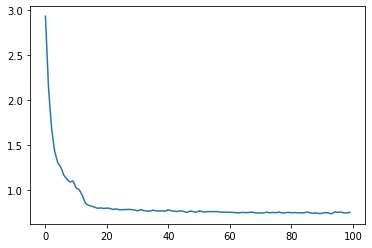

In [27]:
plt.plot(np.load('training_loss.npy', allow_pickle=True))